# Laboratorium 9

### 0. Wczytanie danych
Używając metody `load_svmlight_file` z modułu `sklearn` załaduj plik `lab13_files/breast_cancer`, który składa się z 2 elementów: macierzy `X` o wymiarach `683 x 10` oraz wektora `y` o dlugosci `683`. Macierz `X` opisuje badania 683 pacjentow, a wektor `y` ich diagnozy. 

In [131]:
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split

X, y = load_svmlight_file('lab13_files/breast-cancer')
X = X.toarray()

X, X_test, y, y_test = train_test_split(X, y, train_size=0.8, random_state=32)


### 1. Preprocessing
1.1 Korzystajac z `numpy.where` przenumeruj wektor y, tzn zamień wartości 2 i 4 na -1 i +1. 

1.2 Przeskaluj macierz X, tak żeby wartości w każdej kolumnie mieściły się w zakresie [0,1], innymi słowy przeskaluj niezależnie każdą kolumne $X_j$ wg wzoru:


$$
X_j = \frac{X_j-\min(X_j)}{\max(X_j)-\min(X_j)}
$$

In [132]:
import numpy as np


X = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))


y= np.where(y == 2, -1, np.where(y == 4, 1, y))



### 2. Wizualizacja
Narysuj dane używajac biblioteki `matplotlib`. Użyj wymiarów 1 i 2 z macierzy X, a jako kolory użyj wektora y. Pobaw sie parametrami "s" oraz "alpha" metody `plt.scatter` żeby uzyskać czytelną wizualizacje, np. taką jak poniżej.

<img src="lab13_files/d.png">

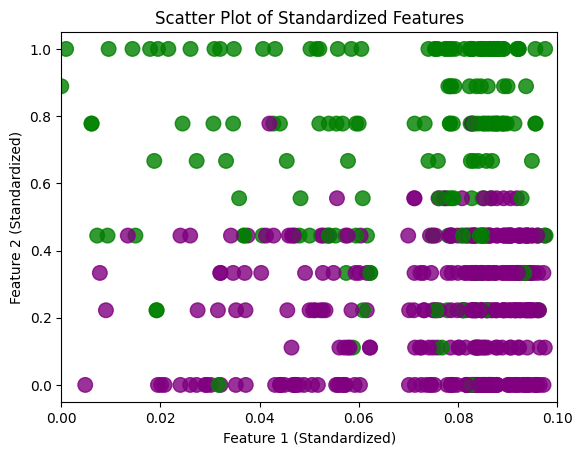

In [134]:
%matplotlib inline
import matplotlib.pyplot as plt


x_axis = X[:, 0]
y_axis = X[:, 1]
colors = np.where(y == -1, 'purple', 'green')

plt.scatter(x_axis, y_axis, s=110, c=colors, alpha=0.8)

plt.xlim(0, 0.1)

plt.xlabel('Feature 1 (Standardized)')
plt.ylabel('Feature 2 (Standardized)')
plt.title('Scatter Plot of Standardized Features')

plt.show()


### 3. Regresja 

Przeprowadź regresje liniową wg wzoru:
$$
\beta = (X^TX)^{-1}X^Ty
$$

In [139]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

model.fit(X, y)

LinearRegression()

### 4. Wizualizacja Regresji

Zwizualizuj dane po zrzutowaniu na $\beta$ używajac metody `plt.hist`, tzn. narysuj histogramy $\beta X_+$ oraz
$\beta X_-$ gdzie $X_+$ to wiersze $X$ dla których $y=+1$ i analogicznie $X_-$. Postaraj się wygenerować czytelny wykres podobny do tego poniżej.

<img src="lab13_files/lr1.png">

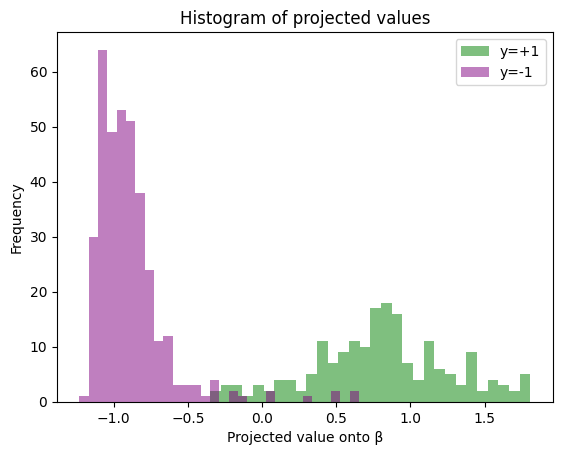

In [143]:
beta = model.coef_  # Coefficients from the linear model
intercept = model.intercept_  # Intercept from the linear model

# Projecting X onto β
# If X does not include an intercept term, add it
X_with_intercept = np.hstack([np.ones((X.shape[0], 1)), X])
projected_X = np.dot(X_with_intercept, np.hstack([intercept, beta]))

# Separating the projected values based on the target y
projected_X_positive = projected_X[y == 1]
projected_X_negative = projected_X[y == -1]

# Plotting histograms
plt.hist(projected_X_positive, bins=30, alpha=0.5, label='y=+1', color='green')
plt.hist(projected_X_negative, bins=30, alpha=0.5, label='y=-1', color='purple')
plt.legend()
plt.xlabel('Projected value onto β')
plt.ylabel('Frequency')
plt.title('Histogram of projected values')
plt.show()


### 5. Klasyfikacja

Przeprowadź "klasyfikacje" naszych pacjentów, ci, którzy zostali zrzutowani na wartość ujemną dostają etykiete $-1$, a ci którzy na wartość dodatnia - etykiete $+1$

In [146]:


X_with_intercept = np.hstack([np.ones((X.shape[0], 1)), X])

# Calculate the projection of X onto β
projected_X = np.dot(X_with_intercept, np.hstack([intercept, beta]))

# Classify the projections into +1 or -1 based on the sign of the projection
classified_labels = np.sign(projected_X)

# In case np.sign returns 0 for any value, which shouldn't be the case in this binary classification,
# we can adjust it to 1 or -1. Here we choose to adjust 0 to 1.
classified_labels[classified_labels == 0] = 1


### 6. Ewaluacja

Policz jak dokładny jest ten model, tzn. jak duży jest zbiór
$ \{ (x_i,y_i) : \mathrm{sign}(\beta x_i) = y_i \} $
w stosunku do rozmiaru całego $y$

Powinno udać się uzyskać wynik na poziomie 93-94%

In [150]:
from sklearn.metrics import accuracy_score



# Calculate predictions based on the sign of the projection
predictions = np.sign(projected_X)

# Adjust predictions in case any are zero (not likely in binary classification, but just in case)
predictions[predictions == 0] = 1

# Calculate accuracy using scikit-learn
accuracy = accuracy_score(y, predictions)

print(f"Model accuracy: {accuracy * 100:.2f}%")



Model accuracy: 96.70%


### 7. Regularyzacja 
Dodaj parametr `C` do regresji liniowej
$$
\beta = (X^TX + \tfrac{1}{C}I)^{-1}X^Ty
$$

gdzie $I$ - macierz identyczności. 

Dla jakiej wartości `C` wynik jest najlepszy? Jaki wynik udało Ci sie uzyskać?

### 8. Gratulacje
Właśnie stworzyłeś/-aś swój pierwszy klasyfikator (statystyczny model predykcji). 

Spróbuj zastosować go do innych danych.

### Zadanie dodatkowe

Zaimplementuj powyższą metode jako klase `LRClassifier` wyposażoną w następujące metody:

* konstruktor przyjmujący dwa parametry: 
    * `C` - stała z równania 
    * `scale` - zmienna boolowska (domyslnie `True`) która określa czy macierz `X` ma byc automatycznie znormalizowana (przeskalowana do `[0,1]`)
* `.fit(X, y)` która spowoduje obliczenie $\beta$, dla `X` - dowolnej macierzy, `y` - wektora etykiet skladajacego sie z dwóch unikalnych wartosci (mogą to byc np. 2 różne stringi)
* `.predict(X)`, która zwróci wektor zawierajacy na `i`tej pozycji etykiete "przewidzianą" przez nasz model (pamiętaj o skalowaniu jesli `scale==True`!)

Przykladowe użycie:

    clf = LRClassifier(C=100)
    Xt = np.array([[1, 0], [1, 1], [1, 2], [1, 3], [1, 4]])
    yt = np.array(['x', 'x', 'y', 'y', 'y'])
    clf.fit(Xt, yt)
    X = np.array([[1, -1], [1, 0.9], [1, 2.1]])
    print(clf.predict(X)) # ['x', 'x', 'y']